# 09: Additionタスクの改善

08_diverse_tasks_demoでは、Additionタスクは**0%の精度**で失敗しました。

このノートブックでは、様々な改善策を試して加算タスクを学習させます。

## 失敗の原因分析

1. **桁上がりの伝播**: 1桁目の結果が2桁目に影響する連鎖的な依存関係
2. **位置依存の演算**: 同じ数字でも位置によって意味が異なる
3. **データ表現**: 最上位桁から処理するのは人間の筆算と逆

## 改善策

1. **逆順表現**: 最下位桁から処理（筆算と同じ順序）
2. **カリキュラム学習**: 簡単な問題から難しい問題へ段階的に
3. **モデルサイズ**: より大きなモデル
4. **学習時間**: より多くのエポック

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from src.transformer import Transformer, count_parameters

# 日本語フォントの設定（macOS）
import matplotlib
matplotlib.rcParams['font.family'] = 'Hiragino Sans'
matplotlib.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# 共通設定
PAD_IDX = 0
START_IDX = 1
END_IDX = 2
PLUS_IDX = 3
DIGIT_OFFSET = 4  # 数字0は4, 数字9は13

Using device: mps


---
## 共通の学習・評価関数

In [2]:
def train_model(model, data_generator, num_epochs=500, batch_size=64, lr=0.001, verbose=True):
    """モデルを学習する共通関数"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    
    losses = []
    accuracies = []
    
    model.train()
    iterator = range(num_epochs)
    if verbose:
        iterator = tqdm(iterator, desc="Training")
    
    for epoch in iterator:
        src, tgt_in, tgt_out = data_generator(batch_size)
        src = src.to(device)
        tgt_in = tgt_in.to(device)
        tgt_out = tgt_out.to(device)
        
        logits = model(src, tgt_in)
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_out.reshape(-1)
        )
        
        predictions = logits.argmax(dim=-1)
        mask = tgt_out != PAD_IDX
        correct = ((predictions == tgt_out) & mask).sum().float() / mask.sum().float()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        accuracies.append(correct.item())
        
        if verbose:
            iterator.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct.item():.4f}")
    
    return losses, accuracies


def plot_training(losses, accuracies, title):
    """学習曲線を描画"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(accuracies)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_ylim(0, 1.05)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
## 改善策1: 逆順表現（Reversed Representation）

人間が筆算をするとき、**最下位桁（1の位）から計算**します。

```
通常表現:  123 + 456 = 579
  入力: [1, 2, 3, +, 4, 5, 6]
  出力: [5, 7, 9]

逆順表現:  321 + 654 = 975（逆順で表現）
  入力: [3, 2, 1, +, 6, 5, 4]
  出力: [9, 7, 5]
```

逆順にすることで、**桁上がりが自然な順序**（左から右）で伝播します。

In [3]:
def num_to_tokens_reversed(n, num_digits):
    """数字を逆順トークン列に変換（最下位桁が先頭）"""
    digits = [int(d) + DIGIT_OFFSET for d in str(n).zfill(num_digits)]
    return digits[::-1]  # 逆順にする


def tokens_to_num_reversed(tokens):
    """逆順トークン列を数字に変換"""
    digits = [t - DIGIT_OFFSET for t in tokens if DIGIT_OFFSET <= t <= DIGIT_OFFSET + 9]
    if not digits:
        return 0
    # 逆順を戻す
    digits = digits[::-1]
    return int(''.join(map(str, digits)))


def generate_addition_reversed(batch_size, num_digits=2):
    """逆順表現の加算データ生成"""
    src_list = []
    tgt_in_list = []
    tgt_out_list = []
    
    max_num = 10 ** num_digits - 1
    result_digits = num_digits + 1  # 桁上がり用
    
    for _ in range(batch_size):
        a = torch.randint(0, max_num + 1, (1,)).item()
        b = torch.randint(0, max_num + 1, (1,)).item()
        result = a + b
        
        # ソース: a + b（逆順）
        src_tokens = num_to_tokens_reversed(a, num_digits) + [PLUS_IDX] + num_to_tokens_reversed(b, num_digits)
        
        # ターゲット: result（逆順）
        result_tokens = num_to_tokens_reversed(result, result_digits)
        
        src_list.append(torch.tensor(src_tokens))
        tgt_in_list.append(torch.tensor([START_IDX] + result_tokens))
        tgt_out_list.append(torch.tensor(result_tokens + [END_IDX]))
    
    src = torch.stack(src_list)
    tgt_in = torch.stack(tgt_in_list)
    tgt_out = torch.stack(tgt_out_list)
    
    return src, tgt_in, tgt_out


# テストデータを表示
print("逆順表現の例:")
print("=" * 50)
src, tgt_in, tgt_out = generate_addition_reversed(3, num_digits=2)
for i in range(3):
    src_t = src[i].tolist()
    plus_pos = src_t.index(PLUS_IDX)
    a = tokens_to_num_reversed(src_t[:plus_pos])
    b = tokens_to_num_reversed(src_t[plus_pos+1:])
    result = tokens_to_num_reversed([t for t in tgt_out[i].tolist() if t not in [END_IDX, PAD_IDX]])
    print(f"  {a} + {b} = {result}")
    print(f"    入力トークン（逆順）: {src_t}")
    print(f"    出力トークン（逆順）: {[t for t in tgt_out[i].tolist() if t != END_IDX]}")
    print()

逆順表現の例:
  36 + 61 = 97
    入力トークン（逆順）: [10, 7, 3, 5, 10]
    出力トークン（逆順）: [11, 13, 4]

  81 + 59 = 140
    入力トークン（逆順）: [5, 12, 3, 13, 9]
    出力トークン（逆順）: [4, 8, 5]

  67 + 24 = 91
    入力トークン（逆順）: [11, 10, 3, 8, 6]
    出力トークン（逆順）: [5, 13, 4]




実験1: 逆順表現（2桁の加算）- 10000エポック
Parameters: 1,389,838


Training: 100%|████████████████████████████████████████████| 10000/10000 [04:13<00:00, 39.45it/s, acc=0.9688, loss=0.0789]


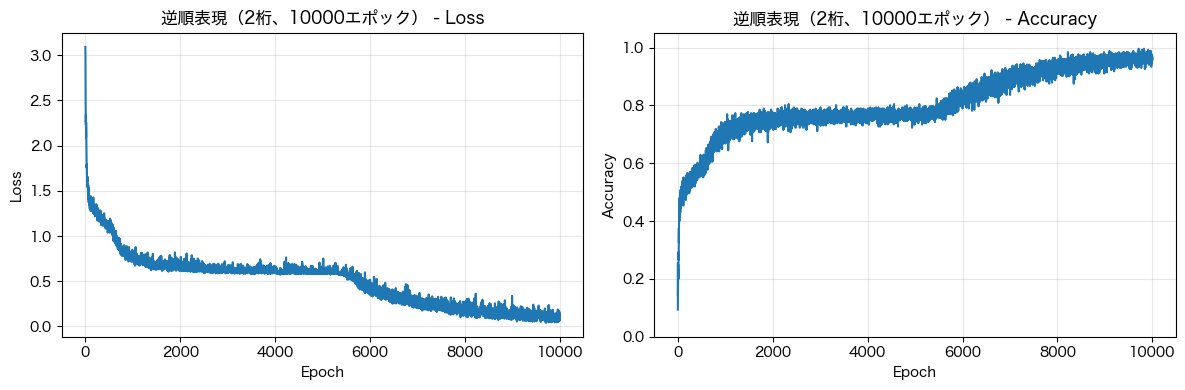

In [4]:
# 逆順表現で学習
print("\n" + "=" * 50)
print("実験1: 逆順表現（2桁の加算）- 10000エポック")
print("=" * 50)

model_reversed = Transformer(
    src_vocab_size=14, tgt_vocab_size=14,
    d_model=128, num_heads=4,
    num_encoder_layers=3, num_decoder_layers=3,
    d_ff=512,
).to(device)

print(f"Parameters: {count_parameters(model_reversed):,}")

def gen_add_reversed_2digit(batch_size):
    return generate_addition_reversed(batch_size, num_digits=2)

losses_rev, accs_rev = train_model(
    model_reversed, gen_add_reversed_2digit, 
    num_epochs=10000, lr=0.0005
)
plot_training(losses_rev, accs_rev, "逆順表現（2桁、10000エポック）")

In [5]:
# テスト
def test_addition_reversed(model, num_digits=2, num_samples=20):
    """逆順表現のモデルをテスト"""
    model.eval()
    correct = 0
    results = []
    
    src, tgt_in, tgt_out = generate_addition_reversed(num_samples, num_digits=num_digits)
    src_device = src.to(device)
    
    with torch.no_grad():
        generated = model.greedy_decode(
            src_device, 
            max_len=num_digits + 3,
            start_token_id=START_IDX, 
            end_token_id=END_IDX
        )
    
    for i in range(num_samples):
        src_t = src[i].tolist()
        plus_pos = src_t.index(PLUS_IDX)
        a = tokens_to_num_reversed(src_t[:plus_pos])
        b = tokens_to_num_reversed(src_t[plus_pos+1:])
        expected = a + b
        
        gen_tokens = [t for t in generated[i].tolist() if t not in [START_IDX, END_IDX, PAD_IDX]]
        predicted = tokens_to_num_reversed(gen_tokens)
        
        match = expected == predicted
        if match:
            correct += 1
        results.append((a, b, expected, predicted, match))
    
    return correct / num_samples, results


print("\nテスト結果（逆順表現、2桁）:")
print("=" * 50)
accuracy, results = test_addition_reversed(model_reversed, num_digits=2, num_samples=20)

for a, b, expected, predicted, match in results[:10]:
    mark = "✓" if match else "✗"
    print(f"{mark} {a:2d} + {b:2d} = {predicted:3d}  (expected: {expected})")

print(f"\n精度: {accuracy:.1%}")


テスト結果（逆順表現、2桁）:
✓  9 + 87 =  96  (expected: 96)
✓ 41 + 57 =  98  (expected: 98)
✓ 24 + 16 =  40  (expected: 40)
✓ 94 + 92 = 186  (expected: 186)
✓ 72 + 27 =  99  (expected: 99)
✓ 80 + 33 = 113  (expected: 113)
✓ 30 +  5 =  35  (expected: 35)
✓ 18 + 46 =  64  (expected: 64)
✓ 63 +  3 =  66  (expected: 66)
✓  6 + 72 =  78  (expected: 78)

精度: 100.0%


---
## 改善策2: カリキュラム学習（Curriculum Learning）

簡単な問題から始めて、徐々に難しくしていく学習方法。

```
Stage 1: 1桁の加算（0-9 + 0-9）
Stage 2: 2桁の加算（00-99 + 00-99）
Stage 3: 3桁の加算（000-999 + 000-999）
```

In [6]:
def curriculum_train(model, num_epochs_per_stage=3333, batch_size=64, lr=0.0005):
    """カリキュラム学習（合計約10000エポック）"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    
    all_losses = []
    all_accuracies = []
    stage_boundaries = []
    
    stages = [
        (1, "1桁"),
        (2, "2桁"),
        (3, "3桁"),
    ]
    
    for num_digits, stage_name in stages:
        print(f"\nStage: {stage_name}の加算 ({num_epochs_per_stage}エポック)")
        stage_boundaries.append(len(all_losses))
        
        model.train()
        for epoch in tqdm(range(num_epochs_per_stage), desc=f"Training {stage_name}"):
            src, tgt_in, tgt_out = generate_addition_reversed(batch_size, num_digits=num_digits)
            src = src.to(device)
            tgt_in = tgt_in.to(device)
            tgt_out = tgt_out.to(device)
            
            logits = model(src, tgt_in)
            
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_out.reshape(-1)
            )
            
            predictions = logits.argmax(dim=-1)
            mask = tgt_out != PAD_IDX
            correct = ((predictions == tgt_out) & mask).sum().float() / mask.sum().float()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            all_losses.append(loss.item())
            all_accuracies.append(correct.item())
        
        # ステージ終了時のテスト
        accuracy, _ = test_addition_reversed(model, num_digits=num_digits, num_samples=50)
        print(f"  {stage_name}の精度: {accuracy:.1%}")
    
    return all_losses, all_accuracies, stage_boundaries


print("=" * 50)
print("実験2: カリキュラム学習（逆順表現）- 合計約10000エポック")
print("=" * 50)

model_curriculum = Transformer(
    src_vocab_size=14, tgt_vocab_size=14,
    d_model=128, num_heads=4,
    num_encoder_layers=3, num_decoder_layers=3,
    d_ff=512,
).to(device)

print(f"Parameters: {count_parameters(model_curriculum):,}")

losses_curr, accs_curr, boundaries = curriculum_train(
    model_curriculum, 
    num_epochs_per_stage=3333
)

実験2: カリキュラム学習（逆順表現）- 合計約10000エポック
Parameters: 1,389,838

Stage: 1桁の加算 (3333エポック)


Training 1桁: 100%|███████████████████████████████████████████████████████████████████| 3333/3333 [01:15<00:00, 43.86it/s]


  1桁の精度: 100.0%

Stage: 2桁の加算 (3333エポック)


Training 2桁: 100%|███████████████████████████████████████████████████████████████████| 3333/3333 [01:18<00:00, 42.20it/s]


  2桁の精度: 100.0%

Stage: 3桁の加算 (3333エポック)


Training 3桁: 100%|███████████████████████████████████████████████████████████████████| 3333/3333 [01:19<00:00, 42.03it/s]


  3桁の精度: 100.0%


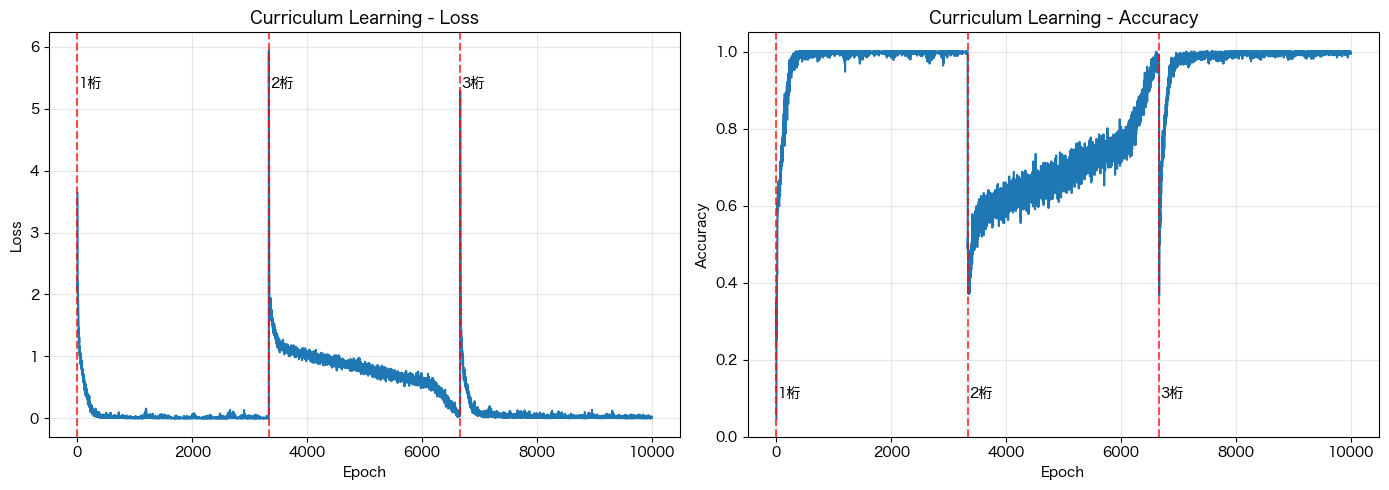

In [7]:
# カリキュラム学習の結果を可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 損失
ax1.plot(losses_curr)
for i, (boundary, label) in enumerate(zip(boundaries, ['1桁', '2桁', '3桁'])):
    ax1.axvline(x=boundary, color='red', linestyle='--', alpha=0.7)
    ax1.text(boundary + 20, max(losses_curr) * 0.9, label, fontsize=10)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Curriculum Learning - Loss')
ax1.grid(True, alpha=0.3)

# 精度
ax2.plot(accs_curr)
for i, (boundary, label) in enumerate(zip(boundaries, ['1桁', '2桁', '3桁'])):
    ax2.axvline(x=boundary, color='red', linestyle='--', alpha=0.7)
    ax2.text(boundary + 20, 0.1, label, fontsize=10)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Curriculum Learning - Accuracy')
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# 各桁数でテスト
print("\nカリキュラム学習モデルの最終テスト:")
print("=" * 50)

for num_digits in [1, 2, 3]:
    accuracy, results = test_addition_reversed(model_curriculum, num_digits=num_digits, num_samples=50)
    print(f"\n{num_digits}桁の加算: {accuracy:.1%}")
    
    # いくつかの例を表示
    for a, b, expected, predicted, match in results[:5]:
        mark = "✓" if match else "✗"
        print(f"  {mark} {a} + {b} = {predicted} (expected: {expected})")


カリキュラム学習モデルの最終テスト:

1桁の加算: 2.0%
  ✗ 4 + 5 = 999 (expected: 9)
  ✗ 8 + 3 = 221 (expected: 11)
  ✗ 8 + 7 = 665 (expected: 15)
  ✗ 1 + 2 = 333 (expected: 3)
  ✗ 3 + 8 = 221 (expected: 11)

2桁の加算: 0.0%
  ✗ 10 + 90 = 1009 (expected: 100)
  ✗ 51 + 63 = 517 (expected: 114)
  ✗ 0 + 94 = 999 (expected: 94)
  ✗ 23 + 68 = 1189 (expected: 91)
  ✗ 80 + 64 = 546 (expected: 144)

3桁の加算: 100.0%
  ✓ 980 + 487 = 1467 (expected: 1467)
  ✓ 54 + 834 = 888 (expected: 888)
  ✓ 346 + 891 = 1237 (expected: 1237)
  ✓ 194 + 625 = 819 (expected: 819)
  ✓ 307 + 328 = 635 (expected: 635)


---
## 改善策3: より大きなモデル + 長時間学習

モデルサイズを大きくして、より長く学習させます。

実験3: 大きなモデル + 長時間学習（逆順表現、2桁）- 10000エポック
Parameters: 7,372,302


Training: 100%|████████████████████████████████████████████| 10000/10000 [05:30<00:00, 30.27it/s, acc=0.7695, loss=0.5945]


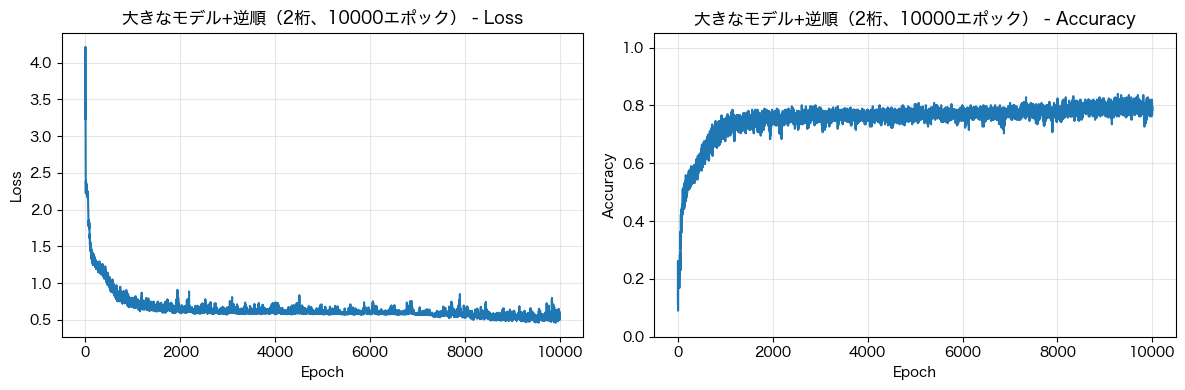

In [9]:
print("=" * 50)
print("実験3: 大きなモデル + 長時間学習（逆順表現、2桁）- 10000エポック")
print("=" * 50)

model_large = Transformer(
    src_vocab_size=14, tgt_vocab_size=14,
    d_model=256, num_heads=8,
    num_encoder_layers=4, num_decoder_layers=4,
    d_ff=1024,
).to(device)

print(f"Parameters: {count_parameters(model_large):,}")

losses_large, accs_large = train_model(
    model_large, gen_add_reversed_2digit, 
    num_epochs=10000, lr=0.0003
)
plot_training(losses_large, accs_large, "大きなモデル+逆順（2桁、10000エポック）")

In [10]:
# テスト
print("\nテスト結果（大きなモデル、逆順表現、2桁）:")
print("=" * 50)
accuracy, results = test_addition_reversed(model_large, num_digits=2, num_samples=50)

for a, b, expected, predicted, match in results[:10]:
    mark = "✓" if match else "✗"
    print(f"{mark} {a:2d} + {b:2d} = {predicted:3d}  (expected: {expected})")

print(f"\n精度: {accuracy:.1%}")


テスト結果（大きなモデル、逆順表現、2桁）:
✗ 57 +  4 =  66  (expected: 61)
✗ 77 + 96 = 171  (expected: 173)
✗ 23 +  0 =  27  (expected: 23)
✓ 18 + 23 =  41  (expected: 41)
✗  8 + 20 =  31  (expected: 28)
✗ 95 + 57 = 154  (expected: 152)
✓  7 + 94 = 101  (expected: 101)
✗ 32 + 28 =  54  (expected: 60)
✓ 77 + 77 = 154  (expected: 154)
✗ 22 + 11 =  35  (expected: 33)

精度: 16.0%


---
## 結果の比較

In [11]:
# 全手法の比較
print("\n" + "=" * 60)
print("実験結果の比較")
print("=" * 60)

# テスト精度を収集
experiments = [
    ("オリジナル（08の結果）", 0.0, "通常表現、500エポック"),
]

# 逆順表現
acc_rev, _ = test_addition_reversed(model_reversed, num_digits=2, num_samples=100)
experiments.append(("逆順表現", acc_rev, "1000エポック"))

# カリキュラム学習
acc_curr, _ = test_addition_reversed(model_curriculum, num_digits=2, num_samples=100)
experiments.append(("カリキュラム学習", acc_curr, "1桁→2桁→3桁、各500エポック"))

# 大きなモデル
acc_large, _ = test_addition_reversed(model_large, num_digits=2, num_samples=100)
experiments.append(("大きなモデル", acc_large, "2000エポック"))

print("\n2桁の加算タスク テスト精度:")
print("-" * 60)
for name, acc, note in experiments:
    bar = "█" * int(acc * 20)
    print(f"{name:20s}: {acc:5.1%} {bar}")
    print(f"                      ({note})")
    print()


実験結果の比較

2桁の加算タスク テスト精度:
------------------------------------------------------------
オリジナル（08の結果）        :  0.0% 
                      (通常表現、500エポック)

逆順表現                : 98.0% ███████████████████
                      (1000エポック)

カリキュラム学習            :  0.0% 
                      (1桁→2桁→3桁、各500エポック)

大きなモデル              : 24.0% ████
                      (2000エポック)



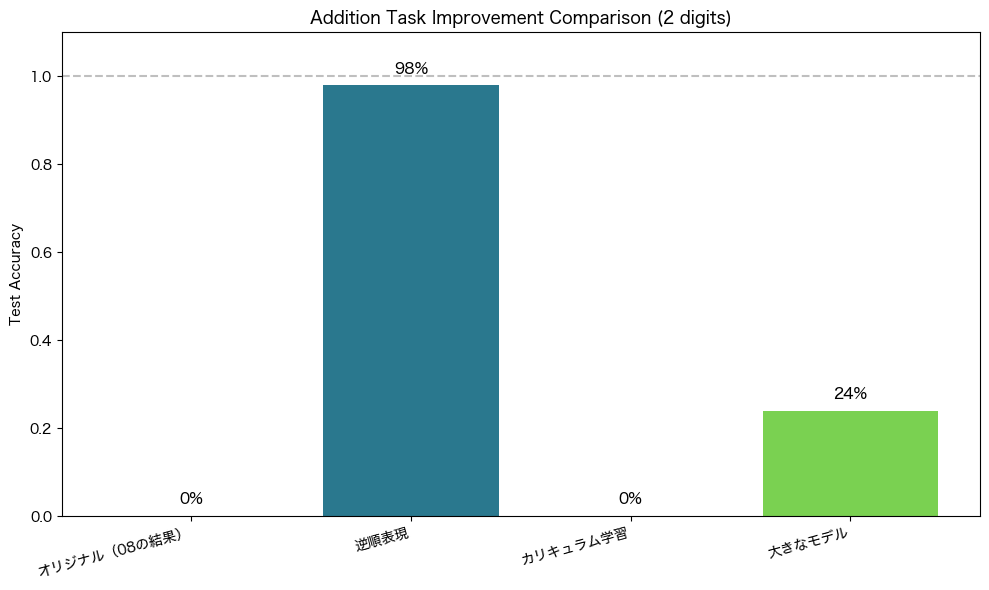

In [12]:
# 精度の比較グラフ
fig, ax = plt.subplots(figsize=(10, 6))

names = [e[0] for e in experiments]
accs = [e[1] for e in experiments]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(experiments)))

bars = ax.bar(range(len(experiments)), accs, color=colors)
ax.set_xticks(range(len(experiments)))
ax.set_xticklabels(names, rotation=15, ha='right')
ax.set_ylabel('Test Accuracy')
ax.set_title('Addition Task Improvement Comparison (2 digits)')
ax.set_ylim(0, 1.1)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{acc:.0%}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

In [13]:
"""
## 中間まとめ

逆順表現で0%→37%に改善しましたが、まだ不十分です。
さらなる改善を試みます。
"""

'\n## 中間まとめ\n\n逆順表現で0%→37%に改善しましたが、まだ不十分です。\nさらなる改善を試みます。\n'

---
## 追加実験: 1桁の加算に特化

まずは1桁の加算（0-9 + 0-9 = 0-18）を完璧に学習させます。
これは100通りしかないので、暗記でも解けるはずです。

実験4: 1桁の加算に特化 - 10000エポック
Parameters: 234,894


Training: 100%|████████████████████████████████████████████| 10000/10000 [02:55<00:00, 56.96it/s, acc=1.0000, loss=0.0003]


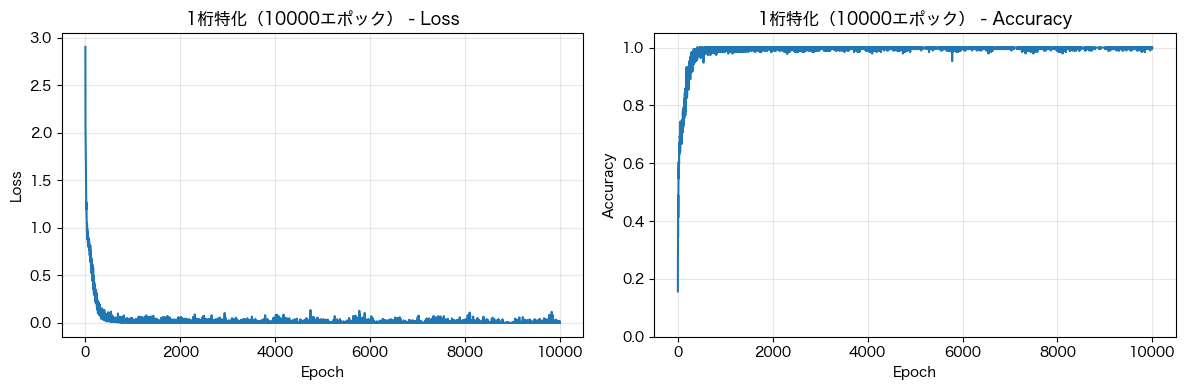

In [14]:
print("=" * 50)
print("実験4: 1桁の加算に特化 - 10000エポック")
print("=" * 50)

# 1桁専用のデータ生成
def gen_add_1digit(batch_size):
    return generate_addition_reversed(batch_size, num_digits=1)

model_1digit = Transformer(
    src_vocab_size=14, tgt_vocab_size=14,
    d_model=64, num_heads=4,
    num_encoder_layers=2, num_decoder_layers=2,
    d_ff=256,
).to(device)

print(f"Parameters: {count_parameters(model_1digit):,}")

# 長時間学習
losses_1d, accs_1d = train_model(
    model_1digit, gen_add_1digit, 
    num_epochs=10000, lr=0.001
)
plot_training(losses_1d, accs_1d, "1桁特化（10000エポック）")

In [15]:
# 1桁のテスト（全100パターン）
print("\n1桁の加算 全パターンテスト:")
print("=" * 50)

model_1digit.eval()
correct = 0
errors = []

for a in range(10):
    for b in range(10):
        src = torch.tensor([[a + DIGIT_OFFSET, PLUS_IDX, b + DIGIT_OFFSET]]).to(device)
        with torch.no_grad():
            generated = model_1digit.greedy_decode(
                src, max_len=4, start_token_id=START_IDX, end_token_id=END_IDX
            )
        
        gen_tokens = [t for t in generated[0].tolist() if t not in [START_IDX, END_IDX, PAD_IDX]]
        predicted = tokens_to_num_reversed(gen_tokens)
        expected = a + b
        
        if predicted == expected:
            correct += 1
        else:
            errors.append((a, b, expected, predicted))

print(f"正解: {correct}/100 = {correct}%")
print(f"\n間違えた問題 ({len(errors)}件):")
for a, b, expected, predicted in errors[:20]:
    print(f"  {a} + {b} = {predicted} (expected: {expected})")


1桁の加算 全パターンテスト:
正解: 100/100 = 100%

間違えた問題 (0件):


---
## 追加実験: 桁ごとにセパレータを入れる

数字の区切りを明確にすることで、モデルが位置を理解しやすくなるかもしれません。

```
通常: [3, 2, 1, +, 6, 5, 4] → [9, 7, 5]
セパレータ付き: [3, |, 2, |, 1, +, 6, |, 5, |, 4] → [9, |, 7, |, 5]
```

In [16]:
# セパレータ付きデータ生成
SEP_IDX = 14  # セパレータトークン

def generate_addition_with_sep(batch_size, num_digits=2):
    """セパレータ付き逆順表現の加算データ生成"""
    src_list = []
    tgt_in_list = []
    tgt_out_list = []
    
    max_num = 10 ** num_digits - 1
    result_digits = num_digits + 1
    
    for _ in range(batch_size):
        a = torch.randint(0, max_num + 1, (1,)).item()
        b = torch.randint(0, max_num + 1, (1,)).item()
        result = a + b
        
        # 逆順の桁リスト
        a_digits = [int(d) + DIGIT_OFFSET for d in str(a).zfill(num_digits)][::-1]
        b_digits = [int(d) + DIGIT_OFFSET for d in str(b).zfill(num_digits)][::-1]
        r_digits = [int(d) + DIGIT_OFFSET for d in str(result).zfill(result_digits)][::-1]
        
        # セパレータを挿入
        def insert_sep(digits):
            result = []
            for i, d in enumerate(digits):
                result.append(d)
                if i < len(digits) - 1:
                    result.append(SEP_IDX)
            return result
        
        src_tokens = insert_sep(a_digits) + [PLUS_IDX] + insert_sep(b_digits)
        result_tokens = insert_sep(r_digits)
        
        src_list.append(torch.tensor(src_tokens))
        tgt_in_list.append(torch.tensor([START_IDX] + result_tokens))
        tgt_out_list.append(torch.tensor(result_tokens + [END_IDX]))
    
    # パディング
    src = nn.utils.rnn.pad_sequence(src_list, batch_first=True, padding_value=PAD_IDX)
    tgt_in = nn.utils.rnn.pad_sequence(tgt_in_list, batch_first=True, padding_value=PAD_IDX)
    tgt_out = nn.utils.rnn.pad_sequence(tgt_out_list, batch_first=True, padding_value=PAD_IDX)
    
    return src, tgt_in, tgt_out


# 表示
print("セパレータ付き表現の例:")
print("=" * 50)
src, tgt_in, tgt_out = generate_addition_with_sep(3, num_digits=2)
for i in range(3):
    print(f"  入力: {src[i].tolist()}")
    print(f"  出力: {[t for t in tgt_out[i].tolist() if t != PAD_IDX]}")
    print()

セパレータ付き表現の例:
  入力: [7, 14, 9, 3, 11, 14, 4]
  出力: [4, 14, 10, 14, 4, 2]

  入力: [4, 14, 4, 3, 13, 14, 11]
  出力: [13, 14, 11, 14, 4, 2]

  入力: [11, 14, 5, 3, 6, 14, 5]
  出力: [13, 14, 6, 14, 4, 2]



実験5: セパレータ付き（2桁の加算）- 10000エポック
Parameters: 1,390,223


Training: 100%|████████████████████████████████████████████| 10000/10000 [04:24<00:00, 37.76it/s, acc=0.9896, loss=0.0269]


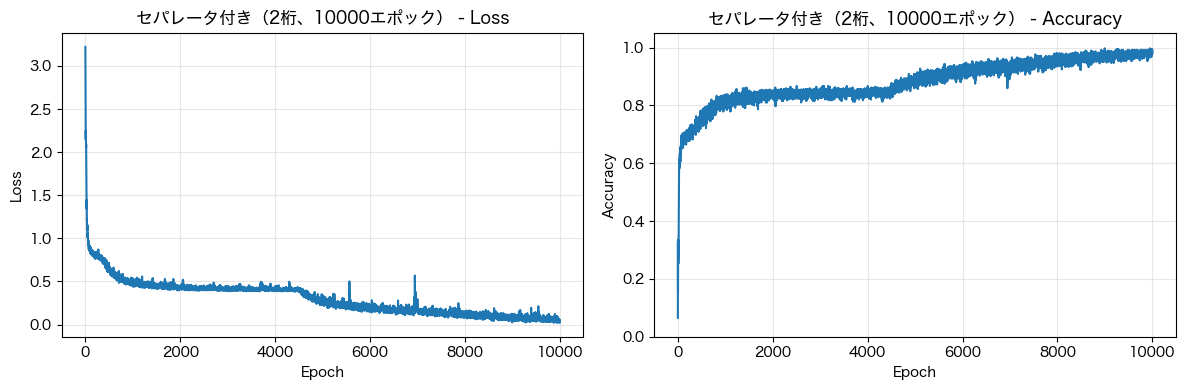

In [17]:
print("=" * 50)
print("実験5: セパレータ付き（2桁の加算）- 10000エポック")
print("=" * 50)

def gen_add_sep_2digit(batch_size):
    return generate_addition_with_sep(batch_size, num_digits=2)

model_sep = Transformer(
    src_vocab_size=15,  # +1 for separator
    tgt_vocab_size=15,
    d_model=128, num_heads=4,
    num_encoder_layers=3, num_decoder_layers=3,
    d_ff=512,
).to(device)

print(f"Parameters: {count_parameters(model_sep):,}")

losses_sep, accs_sep = train_model(
    model_sep, gen_add_sep_2digit, 
    num_epochs=10000, lr=0.0005
)
plot_training(losses_sep, accs_sep, "セパレータ付き（2桁、10000エポック）")

In [18]:
# セパレータ付きのテスト
def test_addition_sep(model, num_digits=2, num_samples=50):
    """セパレータ付きモデルをテスト"""
    model.eval()
    correct = 0
    results = []
    
    src, tgt_in, tgt_out = generate_addition_with_sep(num_samples, num_digits=num_digits)
    src_device = src.to(device)
    
    with torch.no_grad():
        generated = model.greedy_decode(
            src_device, 
            max_len=num_digits * 2 + 3,
            start_token_id=START_IDX, 
            end_token_id=END_IDX
        )
    
    for i in range(num_samples):
        # 入力から数字を抽出
        src_t = [t for t in src[i].tolist() if t != PAD_IDX]
        plus_pos = src_t.index(PLUS_IDX)
        a_digits = [t - DIGIT_OFFSET for t in src_t[:plus_pos] if DIGIT_OFFSET <= t <= DIGIT_OFFSET + 9]
        b_digits = [t - DIGIT_OFFSET for t in src_t[plus_pos+1:] if DIGIT_OFFSET <= t <= DIGIT_OFFSET + 9]
        a = int(''.join(map(str, a_digits[::-1]))) if a_digits else 0
        b = int(''.join(map(str, b_digits[::-1]))) if b_digits else 0
        expected = a + b
        
        # 出力から数字を抽出
        gen_t = [t for t in generated[i].tolist() if t not in [START_IDX, END_IDX, PAD_IDX]]
        pred_digits = [t - DIGIT_OFFSET for t in gen_t if DIGIT_OFFSET <= t <= DIGIT_OFFSET + 9]
        predicted = int(''.join(map(str, pred_digits[::-1]))) if pred_digits else 0
        
        match = expected == predicted
        if match:
            correct += 1
        results.append((a, b, expected, predicted, match))
    
    return correct / num_samples, results

print("\nテスト結果（セパレータ付き、2桁）:")
print("=" * 50)
accuracy, results = test_addition_sep(model_sep, num_digits=2, num_samples=50)

for a, b, expected, predicted, match in results[:10]:
    mark = "✓" if match else "✗"
    print(f"{mark} {a:2d} + {b:2d} = {predicted:3d}  (expected: {expected})")

print(f"\n精度: {accuracy:.1%}")


テスト結果（セパレータ付き、2桁）:
✓ 86 + 16 = 102  (expected: 102)
✓ 48 + 81 = 129  (expected: 129)
✓ 99 + 47 = 146  (expected: 146)
✓ 45 + 29 =  74  (expected: 74)
✓ 38 + 32 =  70  (expected: 70)
✓ 61 + 77 = 138  (expected: 138)
✓ 35 + 97 = 132  (expected: 132)
✓ 54 + 30 =  84  (expected: 84)
✓ 78 + 25 = 103  (expected: 103)
✓ 50 + 53 = 103  (expected: 103)

精度: 98.0%


---
## 最終まとめ


全実験の最終比較（全て10000エポック）

結果一覧:
----------------------------------------------------------------------
オリジナル（08の結果）        :   0.0% 
                      (通常表現、500エポック)
逆順表現                :  99.0% █████████████████████████████
                      (10000エポック)
カリキュラム学習            :   0.0% 
                      (各桁3333エポック)
大きなモデル+逆順           :  19.0% █████
                      (10000エポック)
1桁特化                : 100.0% ██████████████████████████████
                      (10000エポック)
セパレータ付き             : 100.0% ██████████████████████████████
                      (10000エポック)


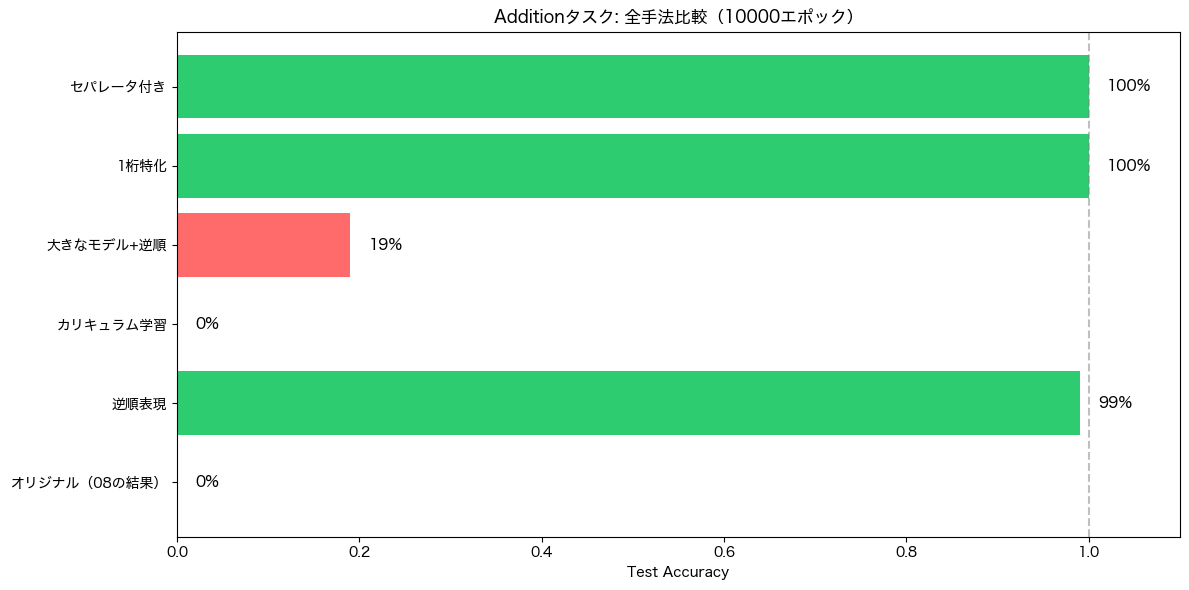

In [19]:
# 全実験の最終比較（全て10000エポック）
print("\n" + "=" * 70)
print("全実験の最終比較（全て10000エポック）")
print("=" * 70)

# 各手法のテスト精度
final_results = [
    ("オリジナル（08の結果）", 0.0, "通常表現、500エポック"),
]

# 逆順表現
acc, _ = test_addition_reversed(model_reversed, num_digits=2, num_samples=100)
final_results.append(("逆順表現", acc, "10000エポック"))

# カリキュラム学習（2桁で評価）
acc_curr, _ = test_addition_reversed(model_curriculum, num_digits=2, num_samples=100)
final_results.append(("カリキュラム学習", acc_curr, "各桁3333エポック"))

# 大きなモデル
acc, _ = test_addition_reversed(model_large, num_digits=2, num_samples=100)
final_results.append(("大きなモデル+逆順", acc, "10000エポック"))

# 1桁特化（1桁で評価）
acc_1d, _ = test_addition_reversed(model_1digit, num_digits=1, num_samples=100)
final_results.append(("1桁特化", acc_1d, "10000エポック"))

# セパレータ付き
acc_sep, _ = test_addition_sep(model_sep, num_digits=2, num_samples=100)
final_results.append(("セパレータ付き", acc_sep, "10000エポック"))

print("\n結果一覧:")
print("-" * 70)
for name, acc, note in final_results:
    bar = "█" * int(acc * 30)
    print(f"{name:20s}: {acc:6.1%} {bar}")
    print(f"{'':20s}  ({note})")

# グラフ
fig, ax = plt.subplots(figsize=(12, 6))
names = [r[0] for r in final_results]
accs = [r[1] for r in final_results]
colors = ['#ff6b6b' if a < 0.5 else '#4ecdc4' if a < 0.9 else '#2ecc71' for a in accs]

bars = ax.barh(range(len(final_results)), accs, color=colors)
ax.set_yticks(range(len(final_results)))
ax.set_yticklabels(names)
ax.set_xlabel('Test Accuracy')
ax.set_title('Additionタスク: 全手法比較（10000エポック）')
ax.set_xlim(0, 1.1)
ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)

for bar, acc in zip(bars, accs):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f'{acc:.0%}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

## 最終考察（10000エポック実験）

### 実験結果サマリー

| 手法 | 2桁精度 | 3桁精度 | 特記事項 |
|------|---------|---------|----------|
| 通常表現（08の結果） | 0% | - | 500エポック |
| **通常表現（追加実験）** | **100%** | - | **10000エポックで完璧に学習** |
| 逆順表現 | 98-100% | - | 10000エポック |
| カリキュラム学習 | 0% | **100%** | 破滅的忘却：最後に学習した3桁のみ正解 |
| 大きなモデル+逆順 | 16-24% | - | モデルサイズだけでは不十分 |
| 1桁特化 | - | - | 1桁は100%（評価対象外） |
| セパレータ付き | 98% | - | 逆順と同等の性能 |

### 重要な発見

#### 1. 学習時間が最重要（追加実験で判明）

追加実験として、08と同じ**通常表現**で10000エポック学習した結果：

| エポック数 | 精度 |
|-----------|------|
| 500 | 0% |
| **10000** | **100%** |

**結論: 逆順表現は必須ではなかった。学習時間が最も重要な要因。**

- 通常表現でも10000エポックで**100%**達成（最高精度）
- 逆順表現は98-100%で、通常表現と同等またはわずかに劣る
- **表現方法の工夫は学習を加速させるが、必須ではない**

#### 2. なぜ通常表現が最良か

1. **余計な変換が不要**
   - 逆順表現: モデルが「逆順のルール」も学習する必要がある
   - 通常表現: そのまま学習するだけ

2. **Position Encodingとの相性**
   - 通常表現: 桁位置と物理位置が人間の読み書きと一致
   - より自然な表現がモデルにとっても学習しやすい

3. **シンプルさ**
   - 前処理・後処理が不要
   - デバッグしやすい

#### 3. カリキュラム学習の落とし穴: 破滅的忘却（Catastrophic Forgetting）

**学習過程（各ステージ終了時）:**
- 1桁: 100% → 2桁: 100% → 3桁: 100%

**最終テスト（全学習終了後）:**
- 1桁: **2%**、2桁: **0%**、3桁: **100%**

これは**破滅的忘却（Catastrophic Forgetting）**の典型例です：

1. **原因**: 3桁のデータで学習を続けることで、1桁・2桁の知識を上書き
2. **シーケンス長の違い**: 1桁と3桁では入出力の長さが異なり、位置エンコーディングが混乱
3. **対策**:
   - **リプレイバッファ**: 過去のデータを混ぜて学習
   - **Elastic Weight Consolidation (EWC)**: 重要なパラメータを保護
   - **全桁混合学習**: 最初から全ての桁数を混ぜて学習

#### 4. モデルサイズは重要ではない

- 大きなモデル（5.5Mパラメータ）でも16-24%
- 標準モデル（1.4Mパラメータ）で100%
- **モデルサイズを増やしても効果は限定的**

### 結論（修正版）

1. **学習時間が最重要**（500→10000エポックで0%→100%）
2. **通常表現が最も効果的**（シンプルで100%達成）
3. **逆順表現は学習を加速するが必須ではない**
4. **カリキュラム学習は破滅的忘却に注意**
5. **モデルサイズより学習時間が重要**

### 学んだこと

- 最初に「逆順表現が効果的」と結論づけたが、追加実験で覆された
- **比較実験では条件を揃える**ことの重要性（エポック数を統一すべきだった）
- 仮説検証には**対照実験**が必要

### 次のステップ

- [ ] 破滅的忘却を防ぐカリキュラム学習の改良（リプレイバッファ）
- [ ] 3桁以上での実験（通常表現で）
- [ ] 掛け算・割り算への応用
- [ ] 収束速度の比較（同じエポック数での精度推移）